# Perceptron

One way to automate classification of objects using their features is to find a decision line in feature space which can separate the classes. In this activity we learn about a simple algorithm to find the decision line. It takes its inspiration from brain cells or neurons.

The earliest mathematical model of a neuron is the McCulloch-Pitts Neuron (MCP) where each input $x_i$ enters through a dendrite with synaptic strength or weight $w_i$. The neuron sums these weighted inputs ($x_iw_i$) and lets the sum, $a$ , act on an activation function, $g$. The result, $z$, is then fired through the output to other neurons. The activation function can be any thresholding function such as a step function, a sigmoid function, or even a Gaussian function. In summary, $$a=\sum_i x_iw_i=x^Tw \quad \text{and} \quad z=g(a)$$.

In [549]:
import numpy as np
import pandas as pd
import cv2, glob, random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from matplotlib.patches import Rectangle
from skimage import color, filters, measure, morphology

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
# plt.rcParams["text.usetex"] = True

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Training data and processing

Code for `jpg2png` function adapted from [this](https://gist.github.com/qingswu/1a58c9d66dfc0a6aaac45528bbe01b82) repository.

In [74]:
def jpg2png(folder):
    jpgimgs = glob.glob("Fruits Dataset/" + str(folder) + "/*.jpg")
    for imgs in jpgimgs:
        img = cv2.imread(imgs)
        cv2.imwrite(imgs[:-3] + 'png', img)

Using the same principles for image thresholding and morphological cleaning for `regionprops`, we have

In [98]:
def NCC(img):
    img = img/255
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    I = R + G + B
    I[I == 0] = 100000
    r, g = R/I, G/I
    b = 1 - r - g
    return r, g, b

In [255]:
def scatter_NCC(img):
    img_r, img_g, img_b = NCC(img)[0], NCC(img)[1], NCC(img)[2]
    channels = [img_r, img_g, img_b]
    for color in channels:
        color[color < 0] = 0
    NCC_plot_colors = list(zip(img_r.flatten(), img_g.flatten(), img_b.flatten()))
    return NCC_plot_colors

The color of objects can also be visualized and quantified by using the CIELAB color space. The 3-dimensional color space is built-up from three axes that are perpendicular to one another. Hue and chroma can be visualized and quantified by using the *a*b-plane of the CIELAB color space. The hue angle range starts, by definition, at the positive side of the a*-axis and goes counter-clockwise. This implies that red has a hue angle of 0°. A full circle goes from 0° to 360°. This means that $$\text{hue} = \tan^{-1} \frac{b^*}{a^*}$$ which will be used later for the feature space extraction.

In [656]:
def rgb2lab(img):
    hueimg = color.rgb2lab(img)
    L, a, b = hueimg[:,:,0], hueimg[:,:,1], hueimg[:,:,2]
    return L, a, b

In [138]:
def fruit_select(fruit_name, data_points = 6):
    cv_img = []
    dataset = glob.glob("Fruits Dataset/" + str(fruit_name) + "/*.png")
    for img in dataset:
        n = cv2.imread(img)
        n = n[:,:,::-1] # reverse color channels
        cv_img.append(n)
        
    filtered_cv_img = random.sample(cv_img, data_points)
    return filtered_cv_img

In [82]:
def fruit_thresh(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = filters.threshold_otsu(img)
    binarized_img = img > thresh
    return binarized_img

In [228]:
def fruit_imshow(fruit_name):
    fig, ax = plt.subplots(1, 6, figsize = (12, 12), tight_layout = True)
    ax = ax.flatten()
    sampleimgs = fruit_select(fruit_name)
    for i, img in enumerate(sampleimgs):
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title("{} {}".format(fruit_name, i+1))

In [708]:
def feature_extract(fruit_name):
    fig, ax = plt.subplots(4, 6, figsize = (12, 8), sharey = "row", constrained_layout = True)
    sampleimgs = fruit_select(fruit_name)
    
    for i, img in enumerate(sampleimgs):
        # imshow the fruits
        ax[0,i].imshow(img)
        ax[0,i].axis("off")
        ax[0,i].set_title("{} {}".format(fruit_name, i+1))
        
        # feature 1 - NCC coordinates
        r, g = NCC(img)[0], NCC(img)[1]
        x_vals = np.linspace(0, 1, 1000)
        ax[1,i].scatter(r, g, alpha = 0.2, s = 1.5, c = scatter_NCC(img))
        ax[1,i].scatter(np.mean(r), np.mean(g), s = 70, color = "black", marker = "x")
        ax[1,i].plot(x_vals, 1 - x_vals, color = "darkgray", linestyle = "--")
        ax[1,i].set_xlabel("$r$")
        ax[1,0].set_ylabel("$g$")
        
        # feature 2 - CIELab coordinates
        a, b = rgb2lab(img)[1], rgb2lab(img)[2]
        ax[2,i].scatter(a, b, alpha = 0.2, s = 1.5, c = scatter_NCC(img))
        ax[2,i].scatter(np.mean(a), np.mean(b), s = 70, color = "black", marker = "x")
        ax[2,i].axhline(0, color = "darkgray", linestyle = "--")
        ax[2,i].axvline(0, color = "darkgray", linestyle = "--")
        ax[2,i].set_xlim(-30, 30)
        ax[2,i].set_ylim(-50, 50)
        ax[2,i].set_xlabel("$a^*$")
        ax[2,0].set_ylabel("$b^*$")
        
        # feature 3 - morphological cleaning and eccentricity
        thresholded = fruit_thresh(img)
        cleaned = morphology.binary_opening(morphology.binary_closing(thresholded))
        cleaned = morphology.remove_small_holes(cleaned, area_threshold = 100)
        
        labels = measure.label(cleaned, background = 1) # setting background fixes centroids
        labels = morphology.remove_small_objects(labels, min_size = 500)
        props = measure.regionprops(labels)
        results = measure.regionprops_table(labels, properties = ("area", "centroid", "eccentricity"))
        df = pd.DataFrame(results)
        
        area = df["area"].to_numpy()
        centroidx = df["centroid-1"].to_numpy()
        centroidy = df["centroid-0"].to_numpy()
        eccentricity = df["eccentricity"].to_numpy()
        
        ax[3,i].imshow(cleaned, cmap = "cividis_r")
        ax[3,i].scatter(centroidx, centroidy, color = "red")
        ax[3,i].set_title("$\epsilon$ = {:.3f}".format(eccentricity[0]), y = -0.18)
        ax[3,i].axis("off")

***

## Feature extraction

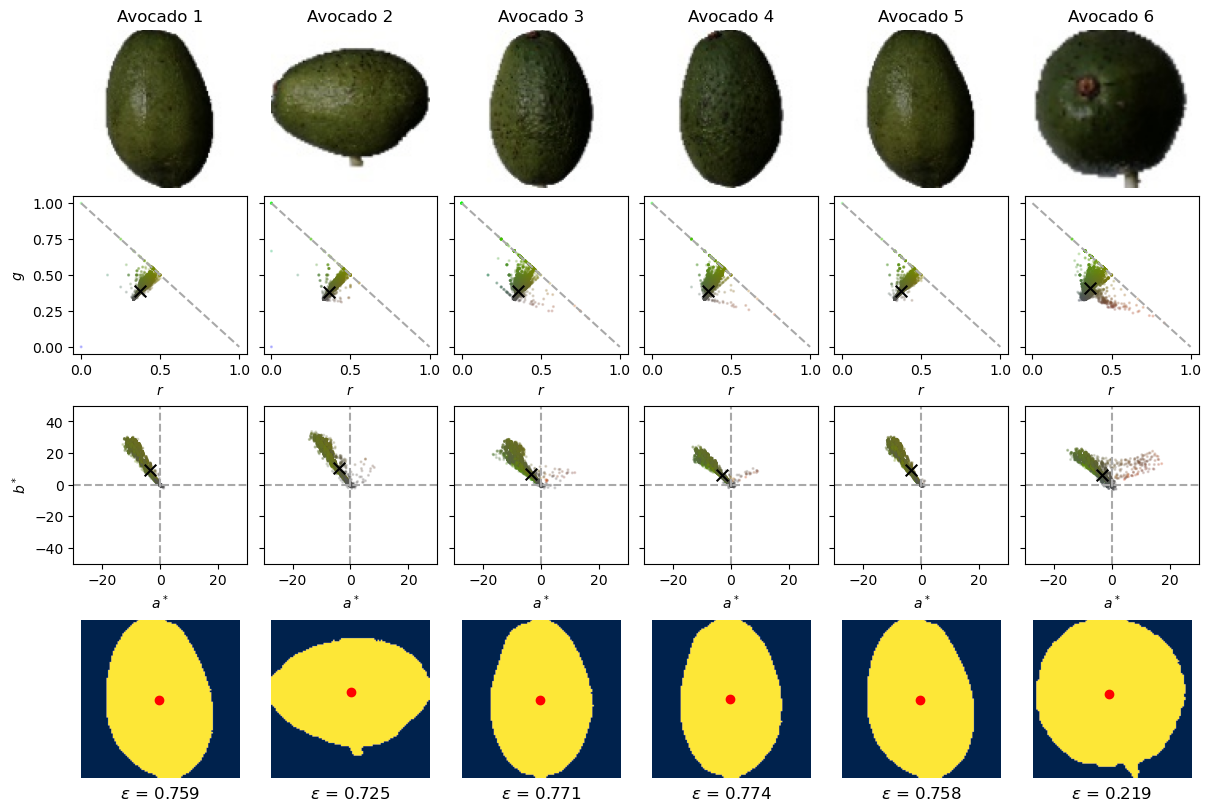

In [709]:
feature_extract("Avocado")

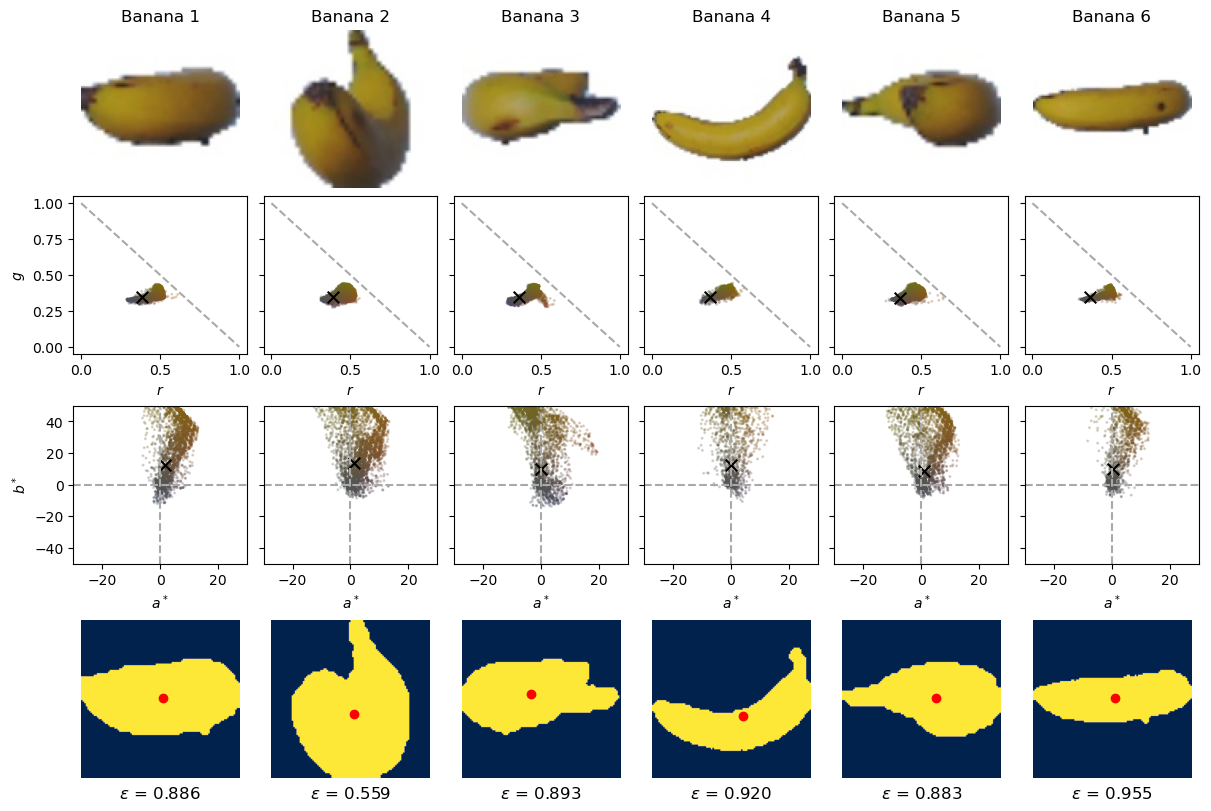

In [710]:
feature_extract("Banana")

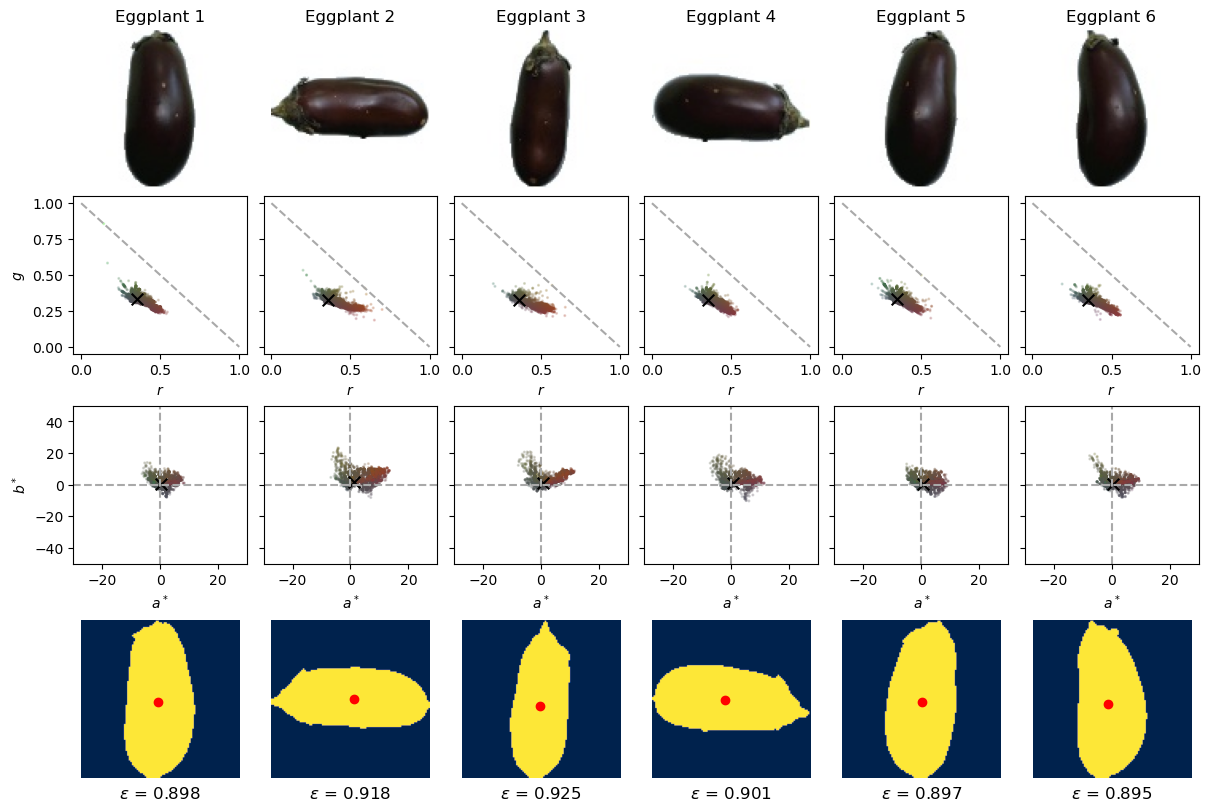

In [711]:
feature_extract("Eggplant")

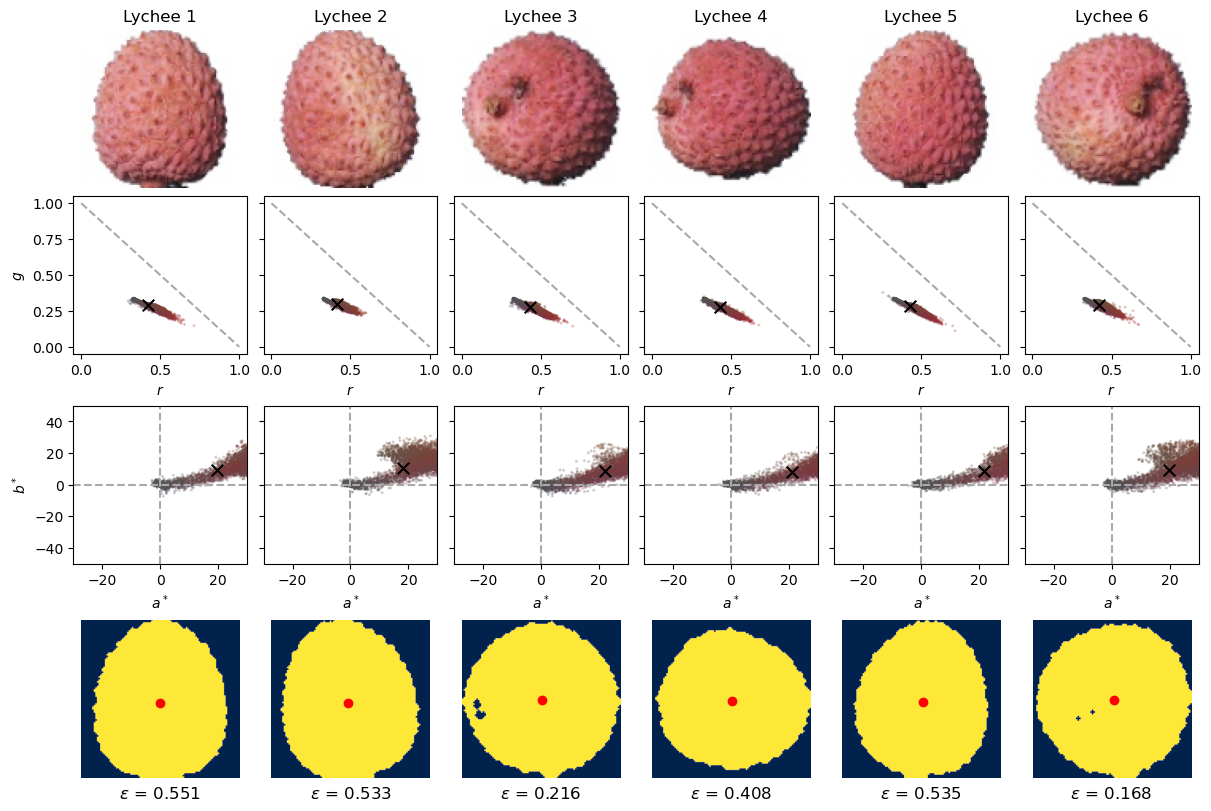

In [712]:
feature_extract("Lychee")

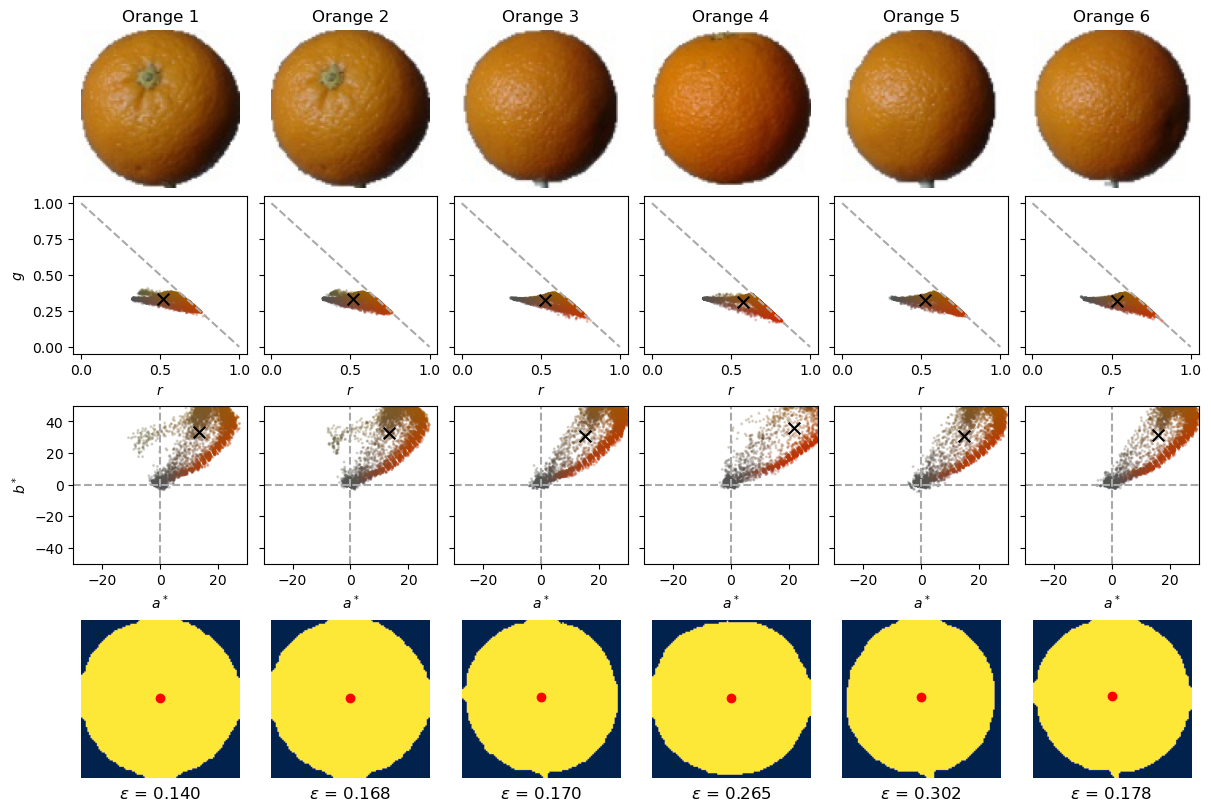

In [713]:
feature_extract("Orange")

***
## Comparisons

## References
1. https://stackoverflow.com/questions/62969818/finding-each-centroid-of-multiple-connected-objects
2. https://stackoverflow.com/questions/67557518/why-lenmeasure-regionpropsimgl-gives-me-a-wrong-number-of-objects
3. https://gist.github.com/qingswu/1a58c9d66dfc0a6aaac45528bbe01b82
4. https://www.ulprospector.com/knowledge/10780/pc-the-cielab-lab-system-the-method-to-quantify-colors-of-coatings/